In [1]:

# data manipulation
import pandas as pd
import numpy as np

# data viz
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.patheffects as path_effects
import seaborn as sns

import re,string

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# apply some cool styling
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [2]:
#read in primary dataset and clean header names
data = pd.read_csv("../data/Supply_Chain_Shipment_Pricing_Dataset_20240302.csv",index_col="id")
data.columns = [i.strip().replace("/","").replace(" ","_").replace("#","num").replace("(","").replace(")","").replace("__","_").lower() for i in data.columns]

#reset index, old index was invalid
#data = data.reset_index(drop=True)

# drop potentially duplicated rows
data = data.drop_duplicates()

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics_cols = data.select_dtypes(include=numerics).columns.tolist()

#replace invalid fields for PO and PQ dates
data['po_sent_to_vendor_date'] = data['po_sent_to_vendor_date'].replace('N/A - From RDC',np.nan).replace('Date Not Captured',np.nan)
data['pq_first_sent_to_client_date'] = data['pq_first_sent_to_client_date'].replace('Pre-PQ Process',np.nan).replace('Date Not Captured',np.nan)

data['freight_cost_usd'] = data['freight_cost_usd'].replace('Freight Included in Commodity Cost',0)



line_item_value = line_item_quantity * pack_price

line_item_value = line_item_quantity * unit_of_measure * unit_price



In [3]:
data[['line_item_value','line_item_insurance_usd']].corr()

,line_item_value,line_item_insurance_usd
line_item_value,1.00000,0.96135
line_item_insurance_usd,0.96135,1.00000


In [4]:
data['line_item_insurance_usd_imp'] = data['line_item_insurance_usd']

data['line_item_insurance_usd_imp_label'] = np.where(data['line_item_insurance_usd'].isna(),1,0)

display(data[['line_item_value','line_item_insurance_usd','line_item_insurance_usd_imp']].isnull().sum())

data['line_item_insurance_usd_imp_label'].value_counts()


line_item_value                  0
line_item_insurance_usd        287
line_item_insurance_usd_imp    287
dtype: int64

line_item_insurance_usd_imp_label
0    10033
1      287
Name: count, dtype: int64

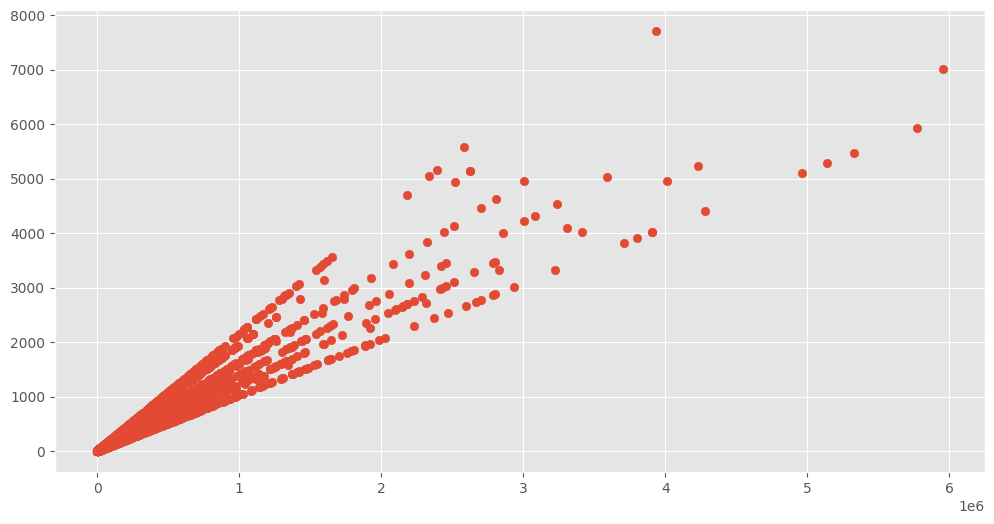

In [5]:
plt.scatter(x=data['line_item_value'],y=data['line_item_insurance_usd'])

In [6]:

data_sm = data[~data['line_item_insurance_usd'].isna()]
data_sm.head()

,project_code,pq_num,po_so_num,asndn_num,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,pq_first_sent_to_client_date,po_sent_to_vendor_date,scheduled_delivery_date,delivered_to_client_date,delivery_recorded_date,product_group,sub_classification,vendor,item_description,moleculetest_type,brand,dosage,dosage_form,unit_of_measure_per_pack,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,line_item_insurance_usd,line_item_insurance_usd_imp,line_item_insurance_usd_imp_label
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69,102-NG-T01,Pre-PQ Process,SCMS-354,ASN-608,Nigeria,PMO - US,Direct Drop,CIP,NaN,NaN,NaN,7-May-07,7-May-07,7-May-07,HRDT,HIV test,ACCOUN NIGERIA LIMITED,"HIV 1/2, Determine Complete HIV Kit, 100 Tests","HIV 1/2, Determine Complete HIV Kit",Determine,NaN,Test kit,100,1500,120000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,True,Weight Captured Separately,0,192.00,192.00,0
81483,108-VN-T30,FPQ-10286,SCMS-156150,ASN-16914,Vietnam,PMO - US,Direct Drop,EXW,Air,7/25/2012,8/15/2012,12-Nov-12,12-Nov-12,12-Nov-12,ARV,Adult,CIPLA LIMITED,"Zidovudine 300mg, tablets, 60 Tabs",Zidovudine,Generic,300mg,Tablet,60,525,3465.0,6.60,0.11,"Cipla, Goa, India",True,34,807.47,4.86,4.86,0
92,102-NG-T01,Pre-PQ Process,SCMS-592,ASN-485,Nigeria,PMO - US,Direct Drop,EXW,Air,NaN,5/13/2007,19-Jun-07,19-Jun-07,19-Jun-07,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit, 100 Tests","HIV 1/2, Determine Complete HIV Kit",Determine,NaN,Test kit,100,1000,80000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,True,341,2682.47,128.00,128.00,0
108,104-CI-T01,Pre-PQ Process,SCMS-698,ASN-727,Côte d'Ivoire,PMO - US,Direct Drop,CIP,Air,NaN,7/13/2007,2-Oct-07,2-Oct-07,2-Oct-07,ARV,Pediatric,BRISTOL-MYERS SQUIBB,"#102198**Didanosine 200mg [Videx], tablets, 60...",Didanosine,Videx,200mg,Tablet,60,5513,140581.5,25.50,0.42,"BMS Meymac, France",True,2126,0,224.93,224.93,0
115,108-VN-T01,Pre-PQ Process,SCMS-753,ASN-781,Vietnam,PMO - US,Direct Drop,EXW,Air,NaN,7/4/2007,15-Oct-07,15-Oct-07,15-Oct-07,ARV,Pediatric,Aurobindo Pharma Limited,"Nevirapine 10mg/ml, oral suspension, Bottle, 2...",Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,1920.0,1.92,0.01,"Aurobindo Unit III, India",True,941,4193.49,3.07,3.07,0


In [7]:
X = np.array(data_sm['line_item_value']).reshape(-1, 1)
y = np.array(data_sm['line_item_insurance_usd'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
  
# Training
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Evaluation
print(f"score: {lin_reg.score(X_test, y_test)}")
print(f"intercept: {lin_reg.intercept_}")
print(f"slope: {lin_reg.coef_}")

for i,r in data.loc[data['line_item_insurance_usd'].isnull()].iterrows():
    data.loc[i,'line_item_insurance_usd_imp'] = lin_reg.predict(np.array(r['line_item_value']).reshape(-1, 1))


score: 0.9171374822740423
intercept: 18.850607072088877
slope: [0.00138719]


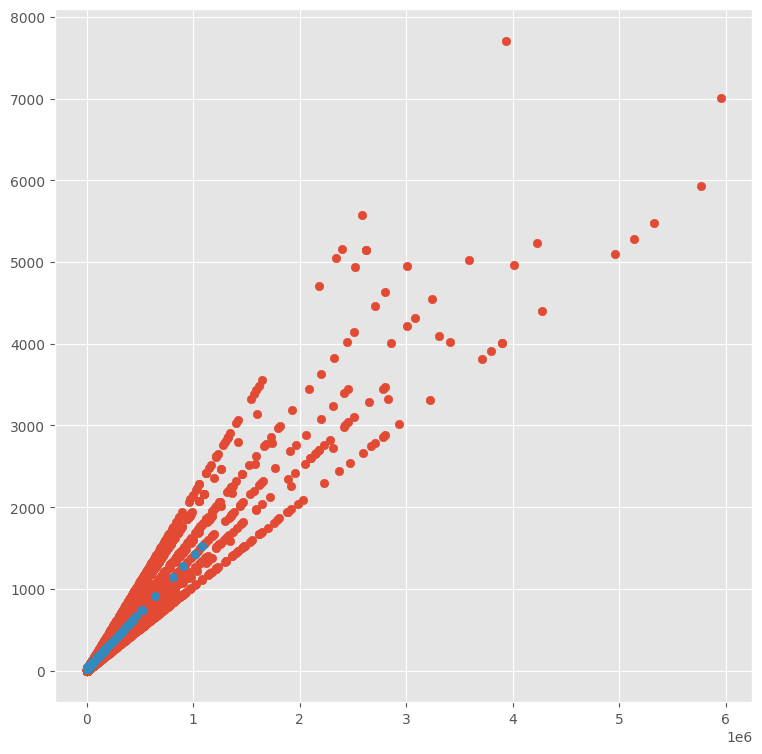

In [8]:
fig, ax = plt.subplots(figsize = (9, 9))
ax.scatter(x=data['line_item_value'],y=data['line_item_insurance_usd'])
ax.scatter(x=data.loc[data['line_item_insurance_usd_imp_label']==1]['line_item_value'],
            y=data.loc[data['line_item_insurance_usd_imp_label']==1]['line_item_insurance_usd_imp'])




In [9]:
data.isnull().sum().to_frame('missing').sort_values('missing',ascending=False)/data.shape[0]

,missing
po_sent_to_vendor_date,0.555136
pq_first_sent_to_client_date,0.259496
dosage,0.168023
shipment_mode,0.034884
line_item_insurance_usd,0.027810
freight_cost_usd,0.000000
weight_kilograms,0.000000
first_line_designation,0.000000
manufacturing_site,0.000000
brand,0.000000


In [10]:
date_cols = ['po_sent_to_vendor_date',
 'scheduled_delivery_date',
 'delivered_to_client_date',
 'delivery_recorded_date',
 'pq_first_sent_to_client_date'
 ]
for d in date_cols:
    data[d] = pd.to_datetime(data[d])
    data[d + '_year'] = data[d].apply(lambda x: x.year)
    
display(data[date_cols])

,po_sent_to_vendor_date,scheduled_delivery_date,delivered_to_client_date,delivery_recorded_date,pq_first_sent_to_client_date
id,,,,,
1,NaT,2006-06-02,2006-06-02,2006-06-02,NaT
3,NaT,2006-11-14,2006-11-14,2006-11-14,NaT
4,NaT,2006-08-27,2006-08-27,2006-08-27,NaT
15,NaT,2006-09-01,2006-09-01,2006-09-01,NaT
16,NaT,2006-08-11,2006-08-11,2006-08-11,NaT
...,...,...,...,...,...
86818,NaT,2015-07-31,2015-07-15,2015-07-20,2014-10-16
86819,NaT,2015-07-31,2015-08-06,2015-08-07,2014-10-24
86821,NaT,2015-08-31,2015-08-25,2015-09-03,2014-08-12


In [11]:
def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = ((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))
   return outliers


def drop_outliers_IQR(df,col):
   q1=df[col].quantile(0.25)
   q3=df[col].quantile(0.75)
   IQR=q3-q1
   non_outliers = df[~((df[col]<(q1-1.5*IQR)) | (df[col]>(q3+1.5*IQR)))]
   return non_outliers

data_drop_outliers = data.copy()

print("original shape:", data_drop_outliers.shape,'\n')

for c in numerics_cols:
   
   outliers = find_outliers_IQR(data[c])
   print("number of outliers: "+ str(len(outliers)))
   print("max outlier value: "+ str(outliers.max()),"min outlier value: "+ str(outliers.min()))
   
   data_drop_ol = drop_outliers_IQR(data_drop_outliers,c)
   print(f"after dropping outliers for {c}:", data_drop_ol.shape,'\n')
   data_drop_outliers = data_drop_ol

original shape: (10320, 39) 

number of outliers: 10320
max outlier value: True min outlier value: False
after dropping outliers for unit_of_measure_per_pack: (9297, 39) 

number of outliers: 10320
max outlier value: True min outlier value: False
after dropping outliers for line_item_quantity: (8138, 39) 

number of outliers: 10320
max outlier value: True min outlier value: False
after dropping outliers for line_item_value: (7450, 39) 

number of outliers: 10320
max outlier value: True min outlier value: False
after dropping outliers for pack_price: (6608, 39) 

number of outliers: 10320
max outlier value: True min outlier value: False
after dropping outliers for unit_price: (5853, 39) 

number of outliers: 10320
max outlier value: True min outlier value: False
after dropping outliers for line_item_insurance_usd: (5422, 39) 



In [12]:
def calc_date_delta(df,d1,d2):
    return (df[d2] - df[d1])/np.timedelta64(1,'D')

data_drop_outliers['days_init_client_vendor'] = calc_date_delta(data_drop_outliers,'pq_first_sent_to_client_date','po_sent_to_vendor_date')

# days planned vendor delivery date
data_drop_outliers['days_vendor_deliver_planned'] = calc_date_delta(data_drop_outliers,'po_sent_to_vendor_date','scheduled_delivery_date')

# days actual vendor delivery date
data_drop_outliers['days_vendor_deliver_actual'] = calc_date_delta(data_drop_outliers,'po_sent_to_vendor_date','delivered_to_client_date')

# diff between planned vs actual
data_drop_outliers['days_transit_delay']  = calc_date_delta(data_drop_outliers,'scheduled_delivery_date','delivered_to_client_date')

# documented delivery date
data_drop_outliers['recorded_date_lag'] = calc_date_delta(data_drop_outliers,'delivered_to_client_date','delivery_recorded_date')

# days until delivery from order
data_drop_outliers['days_from_client_arrival'] = calc_date_delta(data_drop_outliers,'pq_first_sent_to_client_date','delivered_to_client_date')

# days until delivery from order
data_drop_outliers['days_from_vendor_arrival'] = calc_date_delta(data_drop_outliers,'po_sent_to_vendor_date','delivered_to_client_date')



In [13]:
data_drop_outliers['dosage'].unique()

array(['150mg', '30mg', '200mg', '200/50mg', '150/300mg', nan, '300mg',
       '600mg', '25mg', '20mg', '250mg', '400mg', '50+153mg', '100mg',
       '15mg', '600mg/2ml', '150/200/30mg', '100/25mg', '50mg',
       '150/300/200mg', '133.3/33.3mg', '80mg/ml', '30/6mg', '40mg',
       '30/50/6mg', '150/300+200mg', '150/30mg', '150/200/40mg',
       '30mg/ml', '200/300mg', '150/300+300mg', '300/150/300mg',
       '300/300mg', '60/100/12mg', '600/300/300mg', '80/20mg/ml',
       '300/100mg', '30/60mg', '60/30mg', '30/50/60mg', '10mg/ml',
       '125mg', '500/25mg', '600/300mg', '60mg', '600/200/300mg',
       '60/12mg', '50mg/g', '150/300mg+600mg'], dtype=object)

In [14]:
data_drop_outliers[['item_description','dosage']]

,item_description,dosage
id,,
15,"Lamivudine 150mg, tablets, 60 Tabs",150mg
16,"Stavudine 30mg, capsules, 60 Caps",30mg
44,"Efavirenz 200mg [Stocrin/Sustiva], capsule, 90...",200mg
45,"Nevirapine 200mg, tablets, 60 Tabs",200mg
46,"Stavudine 30mg, capsules, 60 Caps",30mg
...,...,...
86815,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",150/300mg
86816,"Efavirenz 600mg, tablets, 30 Tabs",600mg
86819,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",150/300mg


In [15]:
data_drop_outliers.loc[data_drop_outliers['dosage'].isna()][['item_description','dosage']]

,item_description,dosage
id,,
80,"HIV 1/2/O, First Response HIV 1-2.0, v.3.0 Car...",NaN
284,"HIV, Lancet, Safety, for HIV Test kits, 100 Pcs",NaN
305,"HIV, Lancet, Safety, for HIV Test kits, 100 Pcs",NaN
392,"HIV 1/2, Bioline 3.0 Kit, Lancets, Capillary p...",NaN
398,"HIV, Lancet, Safety, for HIV Test kits, 100 Pcs",NaN
...,...,...
80710,"HIV, Lancet, Safety, for HIV Test kits, 100 Pcs",NaN
80872,"HIV 1/2, Bioline 3.0 Kit, Lancets, Capillary p...",NaN
81540,"HIV 1/2, Bioline 3.0 Kit, Lancets, Capillary p...",NaN


In [16]:
data_drop_outliers['dosage'].mode()[0]

'300mg'

In [17]:
data_drop_outliers.loc[data_drop_outliers['item_description'].str.contains('HIV')][['item_description','dosage']]

,item_description,dosage
id,,
80,"HIV 1/2/O, First Response HIV 1-2.0, v.3.0 Car...",NaN
284,"HIV, Lancet, Safety, for HIV Test kits, 100 Pcs",NaN
305,"HIV, Lancet, Safety, for HIV Test kits, 100 Pcs",NaN
392,"HIV 1/2, Bioline 3.0 Kit, Lancets, Capillary p...",NaN
398,"HIV, Lancet, Safety, for HIV Test kits, 100 Pcs",NaN
...,...,...
80710,"HIV, Lancet, Safety, for HIV Test kits, 100 Pcs",NaN
80872,"HIV 1/2, Bioline 3.0 Kit, Lancets, Capillary p...",NaN
81540,"HIV 1/2, Bioline 3.0 Kit, Lancets, Capillary p...",NaN


In [18]:
data_drop_outliers[['item_description','dosage']]

,item_description,dosage
id,,
15,"Lamivudine 150mg, tablets, 60 Tabs",150mg
16,"Stavudine 30mg, capsules, 60 Caps",30mg
44,"Efavirenz 200mg [Stocrin/Sustiva], capsule, 90...",200mg
45,"Nevirapine 200mg, tablets, 60 Tabs",200mg
46,"Stavudine 30mg, capsules, 60 Caps",30mg
...,...,...
86815,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",150/300mg
86816,"Efavirenz 600mg, tablets, 30 Tabs",600mg
86819,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",150/300mg
